In [5]:
from scapy.all import rdpcap, wrpcap, Ether, CookedLinux, IP, IPv6, TCP, UDP, ICMP
from scapy.layers.inet6 import ICMPv6EchoRequest, ICMPv6EchoReply
from scapy.contrib.gtp import GTP_U_Header
import os, numpy as np

ZERO_MAC = "00:00:00:00:00:00"

def _zero_all_ip_layers(pkt):
    # Scrub every IPv4 occurrence
    i = 1
    while True:
        ip = pkt.getlayer(IP, i)
        if not ip:
            break
        ip.src = "0.0.0.0"
        ip.dst = "0.0.0.0"
        if hasattr(ip, "chksum"):
            del ip.chksum
        i += 1

    # Scrub every IPv6 occurrence
    i = 1
    while True:
        ip6 = pkt.getlayer(IPv6, i)
        if not ip6:
            break
        ip6.src = "::"
        ip6.dst = "::"
        i += 1

    # Clear all transport checksums (outer + inner)
    for L in (TCP, UDP, ICMP, ICMPv6EchoRequest, ICMPv6EchoReply):
        j = 1
        while True:
            lay = pkt.getlayer(L, j)
            if not lay:
                break
            # chksum for IPv4 transports, cksum for some IPv6 ICMP variants
            if hasattr(lay, "chksum"):
                del lay.chksum
            if hasattr(lay, "cksum"):
                del lay.cksum
            j += 1

def _force_gtp_dissection(pkt):
    """Ensure UDP/2152 payload is parsed as GTP so inner IP is visible."""
    if UDP in pkt and (pkt[UDP].sport == 2152 or pkt[UDP].dport == 2152):
        try:
            if not pkt.haslayer(GTP_U_Header):
                gtp = GTP_U_Header(bytes(pkt[UDP].payload))
                pkt[UDP].remove_payload()
                pkt[UDP].add_payload(gtp)
        except Exception:
            pass

def remove_ip(packet):
    # L2 anonymization
    if Ether in packet:
        packet[Ether].src = ZERO_MAC
        packet[Ether].dst = ZERO_MAC
    elif CookedLinux in packet:
        packet[CookedLinux].src = ZERO_MAC

    _force_gtp_dissection(packet)
    _zero_all_ip_layers(packet)
    return packet

def packet_to_bytes(pkt, max_len):
    pkt = remove_ip(pkt)
    raw = bytes(pkt)
    return raw[:max_len] if len(raw) > max_len else raw.ljust(max_len, b"\x00")

def extract_raw_bytes_from_folder(folder_path, max_len=100):
    all_features = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(".pcap"):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            all_features.extend(packet_to_bytes(pkt, max_len) for pkt in packets)
    return np.array([np.frombuffer(x, dtype=np.uint8) for x in all_features])


In [6]:
from scapy.all import rdpcap, wrpcap

def extract_raw_bytes_and_save_from_folder(folder_path, max_len=100, save_pcap_path=None):
    all_features = []
    all_packets = []

    for file in os.listdir(folder_path):
        if file.lower().endswith('.pcap'):
            file_path = os.path.join(folder_path, file)
            print(f"Processing {file_path}")
            packets = rdpcap(file_path)
            for pkt in packets:
                pkt = remove_ip(pkt)
                all_packets.append(pkt)
                raw = bytes(pkt)
                raw_padded = raw.ljust(max_len, b'\x00')[:max_len]
                all_features.append(np.frombuffer(raw_padded, dtype=np.uint8))

    if save_pcap_path:
        wrpcap(save_pcap_path, all_packets)

    return np.array(all_features), all_packets  # X_attack, packets_attack
    

attack_folder = r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack"
X_attack, packets_attack = extract_raw_bytes_and_save_from_folder(attack_folder, save_pcap_path=r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\anonymized_attack_new.pcap")

In [2]:
normal_folder = r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal"
attack_folder = r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack"

# Extract and label
X_normal = extract_raw_bytes_from_folder(normal_folder)
X_attack = extract_raw_bytes_from_folder(attack_folder)

y_normal = np.zeros(X_normal.shape[0])
y_attack = np.ones(X_attack.shape[0])

# Combine data and labels
X = np.vstack((X_normal, X_attack))
y = np.hstack((y_normal, y_attack))

Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal\SYNScan_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal\TCPConnect_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal\Torshammer_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal\UDPflood_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_normal\UDPScan_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\Goldeneye_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\ICMPflood_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\Slowloris_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\SYNflood_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\SYNScan_BS1.pcapng
Processing C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\BS1_attack\SYNScan_BS2.pcapng
Processing C:\Users\ulami\Desktop\datase

In [3]:
X_normal.shape

(1535893, 100)

In [4]:
from sklearn.model_selection import train_test_split

# Combine for full dataset
X_all = np.vstack((X_normal, X_attack))
y_all = np.hstack((y_normal, y_attack))

# Normalize data before splitting
X_all = X_all.astype(np.float32) / 255.0

attack_start_idx = len(X_normal)
all_indices = np.arange(len(X_all))

# Split dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all, y_all, all_indices, test_size=0.2, random_state=42, stratify=y_all
)

# CNN reshape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [19]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\5G_NIDD_csv_final.keras")   

In [20]:
final_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,397 (40.62 KB)

 Trainable params: 3,465 (13.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,932 (27.08 KB)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(input_dim: int):
    m = Sequential()
    n_channels = 1
    m.add(Input(shape=(input_dim, n_channels)))

    for i in range(best_params['n_layers']):
        filters = best_params.get(f"n_units_l{i}")            # use your existing units as conv filters
        ksize   = 5
        dr      = best_params.get(f"dropout_l{i}", 0.0)
        poolsz  = best_params.get(f"pool_size_l{i}")          # set >1 to enable per-layer pooling

        m.add(Conv1D(filters=filters, kernel_size=ksize,
                     activation='relu', padding='same'))
        if poolsz and poolsz > 1:
            m.add(MaxPooling1D(pool_size=poolsz))
        if dr and dr > 0:
            m.add(Dropout(dr))

    m.add(GlobalMaxPooling1D())
    m.add(Dense(4, activation='relu'))
    m.add(Dense(1, activation='sigmoid'))

    m.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m


In [13]:
best_params = {
    'epochs': 3,
    'n_layers': 2,
    'n_units_l0': 32, 'dropout_l0': 0.2,
    'n_units_l1': 32, 'dropout_l1': 0.2,
    # 'n_units_l2': 8,  'dropout_l2': 0.0,
    # 'n_units_l2': 32, 'dropout_l2': 0.1,
    'learning_rate': 1e-3,
    'batch_size': 32
}

In [138]:
model = build_model(input_dim=X_train.shape[1])
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_56 (Conv1D)              │ (None, 100, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 100, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_20         │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model = build_model(input_dim=X_train.shape[1])
model.fit(
    X_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1
)

test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

Epoch 1/3
45132/45132 ━━━━━━━━━━━━━━━━━━━━ 150s 3ms/step - accuracy: 0.9680 - loss: 0.0762 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 2/3
45132/45132 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 3/3
45132/45132 ━━━━━━━━━━━━━━━━━━━━ 147s 3ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9997 - val_loss: 0.0015
14104/14104 ━━━━━━━━━━━━━━━━━━━━ 12s 872us/step


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_preds = (model.predict(X_test, verbose=1).ravel() > 0.5).astype(int)

accuracy = accuracy_score(y_test, test_preds)
precision = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

14104/14104 ━━━━━━━━━━━━━━━━━━━━ 12s 839us/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00


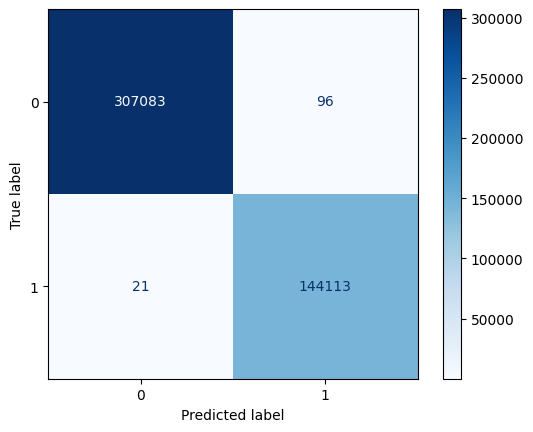

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    307179
        Attack       1.00      1.00      1.00    144134

      accuracy                           1.00    451313
     macro avg       1.00      1.00      1.00    451313
  weighted avg       1.00      1.00      1.00    451313



In [16]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, test_preds, target_names=['Normal Traffic', 'Attack']))

In [17]:
# Save the trained model
model.save("5G_nidd_pcap_final.keras")

In [ ]:
from tensorflow.keras.models import load_model
final_model = load_model(r"C:\Users\ulami\Desktop\magisterka\models_final\5G_NIDD_csv_final.keras")   

# Integrated gradient

In [18]:
def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=input_tensor.shape) # średnia / średnia normalnych / mediana normalnych ?? 

    interpolated_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(steps + 1)
    ]

    grads = []
    for inp in interpolated_inputs:
        with tf.GradientTape() as tape:
            tape.watch(inp)
            pred = model(inp)
        grad = tape.gradient(pred, inp)
        grads.append(grad.numpy())

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (input_tensor.numpy() - baseline.numpy()) * avg_grads
    return integrated_grads.squeeze()

def compute_ig_for_samples(model, X_subset, steps=50, max_samples=100, baseline=None):
    attributions_list = []
    for i in range(min(len(X_subset), max_samples)):
        input_sample = tf.convert_to_tensor([X_subset[i]], dtype=tf.float32)
        ig = compute_integrated_gradients(model, input_sample, baseline=baseline, steps=steps)
        attributions_list.append(ig)
    return np.array(attributions_list)

# Separate test samples
X_normal_test = X_test[y_test == 0]
X_attack_test = X_test[y_test == 1]


In [19]:
a_normal_min = X_normal_test.shape[0] *0.01
a_normal_max = X_normal_test.shape[0] *0.05

a_attack_min = X_attack_test.shape[0] *0.01
a_attack_max = X_attack_test.shape[0] *0.05

a_normal_min, a_normal_max, a_attack_min, a_attack_max

(3071.79, 15358.95, 1441.34, 7206.700000000001)

In [20]:
import pandas as pd
import tensorflow as tf

# Compute IG
normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=3000)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000)

# Average IG
avg_normal_ig = np.mean(normal_attributions, axis=0)
avg_attack_ig = np.mean(attack_attributions, axis=0)


In [76]:
# Normal
df_normal = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_ig)),
    "Attribution (Normal Class)": avg_normal_ig
})
df_normal["Abs Attribution"] = np.abs(df_normal["Attribution (Normal Class)"])
df_normal_sorted = df_normal.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_ig)),
    "Attribution (Attack Class)": avg_attack_ig
})
df_attack["Abs Attribution"] = np.abs(df_attack["Attribution (Attack Class)"])
df_attack_sorted = df_attack.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_sorted.head(20), df_attack_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 41          41                   -0.480122         0.480122
 38          38                   -0.156957         0.156957
 43          43                    0.124393         0.124393
 71          71                    0.045199         0.045199
 75          75                   -0.044670         0.044670
 42          42                   -0.040421         0.040421
 39          39                    0.038633         0.038633
 45          45                   -0.032198         0.032198
 69          69                    0.031296         0.031296
 95          95                   -0.030833         0.030833
 91          91                   -0.028550         0.028550
 92          92                   -0.027849         0.027849
 90          90                   -0.026286         0.026286
 94          94                   -0.026069         0.026069
 89          89                   -0.024047         0.024047
 44          44         

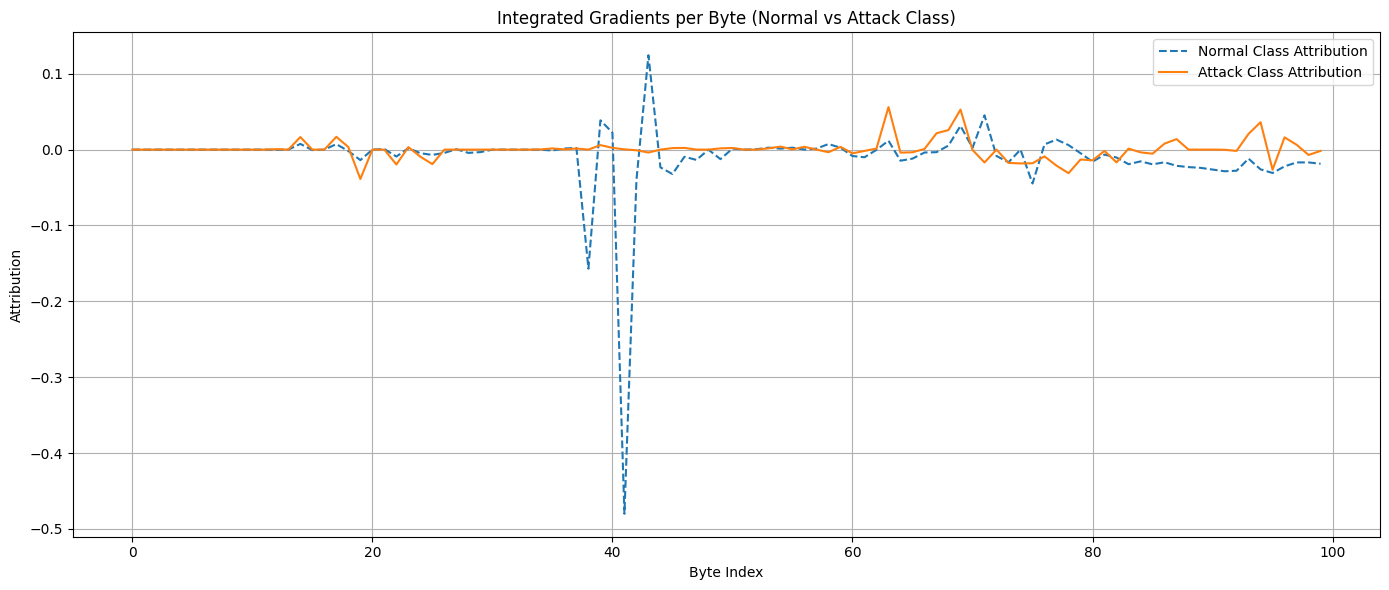

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# After addresses removal
# Normal
df_normal = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_ig)),
    "Attribution (Normal Class)": avg_normal_ig
})
df_normal["Abs Attribution"] = np.abs(df_normal["Attribution (Normal Class)"])
df_normal_sorted = df_normal.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_ig)),
    "Attribution (Attack Class)": avg_attack_ig
})
df_attack["Abs Attribution"] = np.abs(df_attack["Attribution (Attack Class)"])
df_attack_sorted = df_attack.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_sorted.head(20), df_attack_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 41          41                   -0.214210         0.214210
 99          99                   -0.079111         0.079111
 43          43                    0.063259         0.063259
 53          53                    0.048224         0.048224
 58          58                    0.046097         0.046097
 26          26                   -0.044028         0.044028
 46          46                   -0.037480         0.037480
 97          97                   -0.035061         0.035061
 49          49                    0.034793         0.034793
 64          64                    0.031995         0.031995
 24          24                    0.030870         0.030870
 60          60                    0.030258         0.030258
 25          25                   -0.027740         0.027740
 55          55                    0.027442         0.027442
 42          42                   -0.026261         0.026261
 75          75         

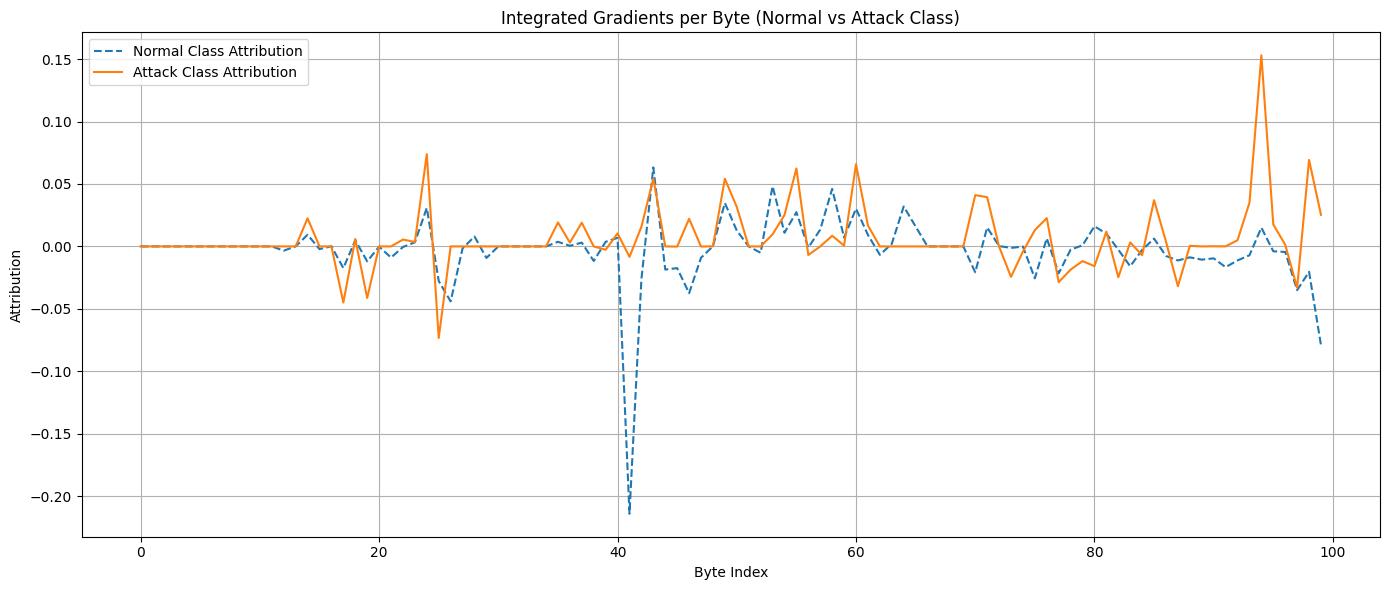

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Baseline - mean

In [23]:
# mean of normal test samples as a baseline
normal_mean = np.mean(X_normal_test, axis=0)
baseline_tensor = tf.convert_to_tensor([normal_mean], dtype=tf.float32)

normal_attributions = compute_ig_for_samples(model, X_normal_test, max_samples=1000, baseline=baseline_tensor)
attack_attributions = compute_ig_for_samples(model, X_attack_test, max_samples=1000, baseline=baseline_tensor)


In [24]:
# Average IG
avg_normal_mean_ig = np.mean(normal_attributions, axis=0)
avg_attack_mean_ig = np.mean(attack_attributions, axis=0)

In [80]:
# Normal
df_normal_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_mean_ig)),
    "Attribution (Normal Class)": avg_normal_mean_ig
})
df_normal_mean["Abs Attribution"] = np.abs(df_normal_mean["Attribution (Normal Class)"])
df_normal_mean_sorted = df_normal_mean.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_mean_ig)),
    "Attribution (Attack Class)": avg_attack_mean_ig
})
df_attack_mean["Abs Attribution"] = np.abs(df_attack_mean["Attribution (Attack Class)"])
df_attack_mean_sorted = df_attack_mean.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_mean_sorted.head(20), df_attack_mean_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 75          75                    0.001524         0.001524
 81          81                   -0.001366         0.001366
 26          26                    0.000580         0.000580
 76          76                   -0.000478         0.000478
 47          47                   -0.000378         0.000378
 82          82                   -0.000372         0.000372
 80          80                    0.000346         0.000346
 79          79                   -0.000311         0.000311
 99          99                    0.000219         0.000219
 65          65                   -0.000215         0.000215
 83          83                   -0.000210         0.000210
 38          38                   -0.000200         0.000200
 29          29                    0.000196         0.000196
 67          67                    0.000171         0.000171
 70          70                    0.000169         0.000169
 78          78         

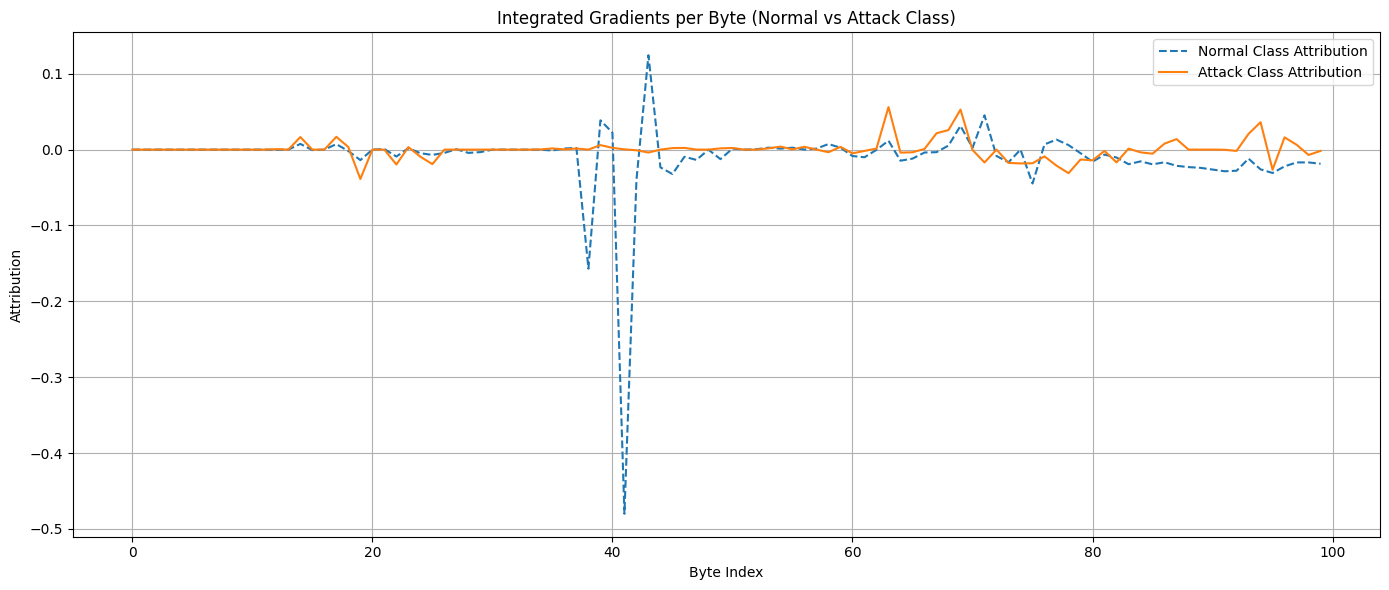

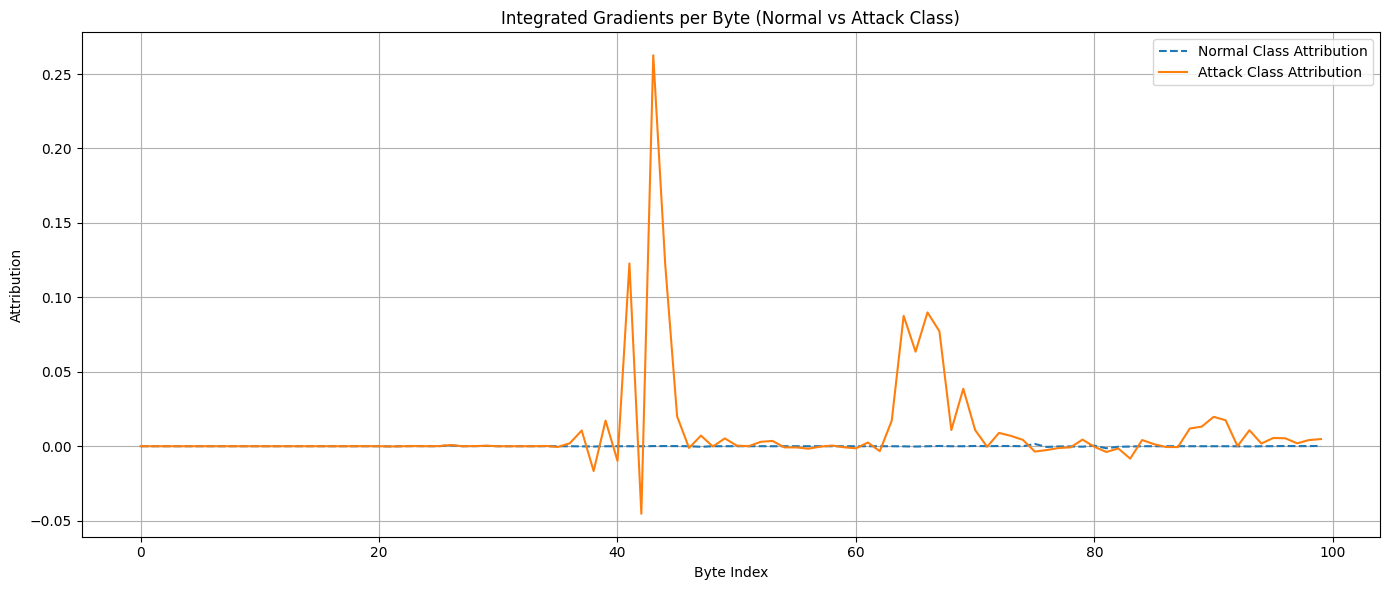

In [81]:
import matplotlib.pyplot as plt
# baseline [0..0]
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# baseline mean
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_mean_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_mean_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# after add removal
# Normal
df_normal_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_normal_mean_ig)),
    "Attribution (Normal Class)": avg_normal_mean_ig
})
df_normal_mean["Abs Attribution"] = np.abs(df_normal_mean["Attribution (Normal Class)"])
df_normal_mean_sorted = df_normal_mean.sort_values("Abs Attribution", ascending=False)

# Attack
df_attack_mean = pd.DataFrame({
    "Byte Index": np.arange(len(avg_attack_mean_ig)),
    "Attribution (Attack Class)": avg_attack_mean_ig
})
df_attack_mean["Abs Attribution"] = np.abs(df_attack_mean["Attribution (Attack Class)"])
df_attack_mean_sorted = df_attack_mean.sort_values("Abs Attribution", ascending=False)

# Display top 20
df_normal_mean_sorted.head(20), df_attack_mean_sorted.head(20)

(    Byte Index  Attribution (Normal Class)  Abs Attribution
 47          47                    0.024051         0.024051
 45          45                   -0.020071         0.020071
 40          40                   -0.012044         0.012044
 26          26                   -0.010584         0.010584
 58          58                    0.010293         0.010293
 96          96                    0.009952         0.009952
 37          37                   -0.009372         0.009372
 52          52                    0.009207         0.009207
 38          38                   -0.007521         0.007521
 99          99                    0.007389         0.007389
 64          64                   -0.006234         0.006234
 75          75                    0.005809         0.005809
 28          28                   -0.005096         0.005096
 59          59                    0.004785         0.004785
 71          71                    0.004226         0.004226
 65          65         

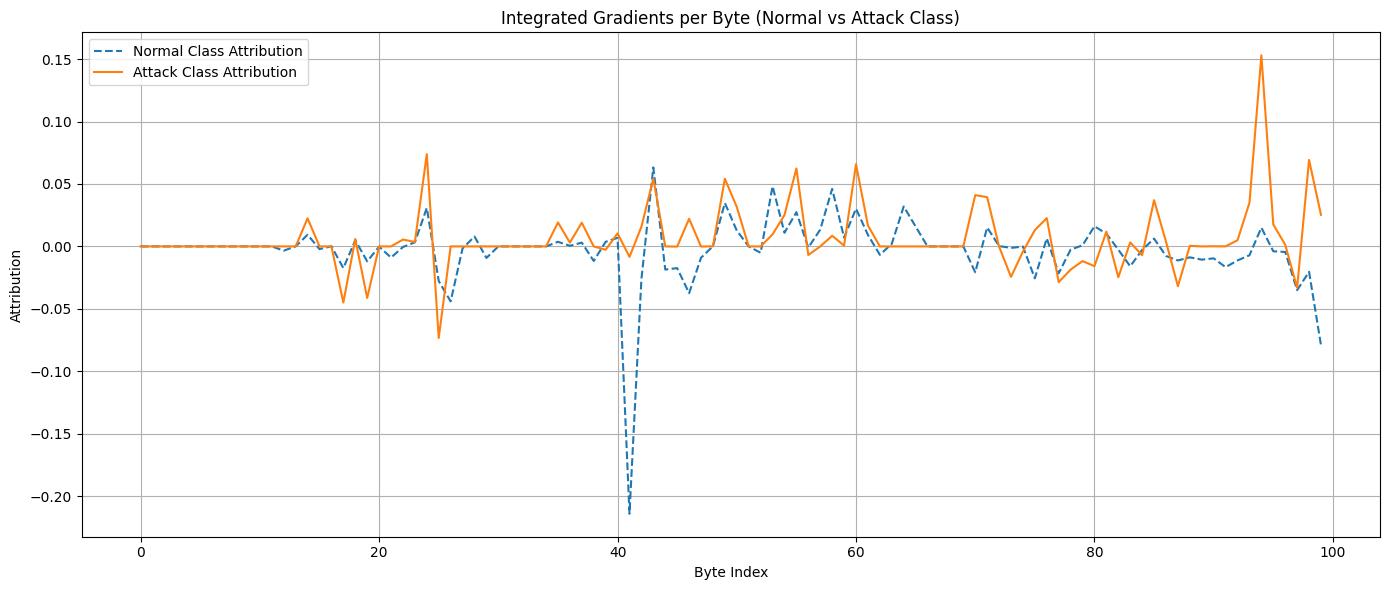

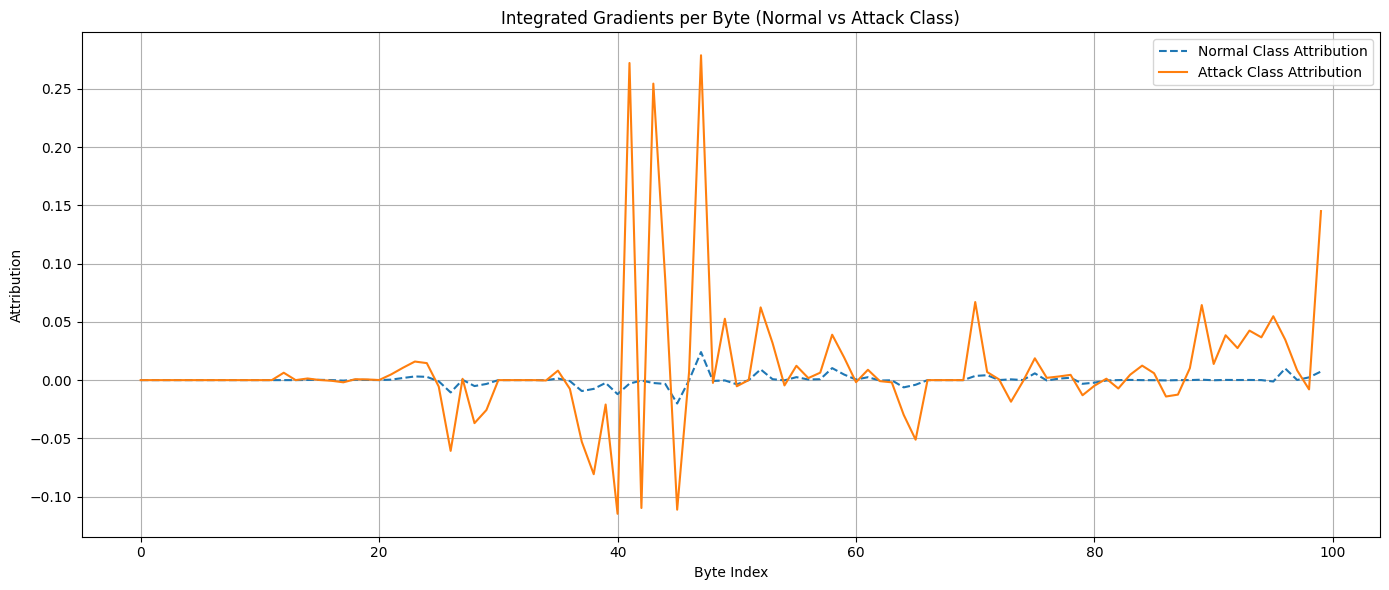

In [26]:
import matplotlib.pyplot as plt
# baseline [0..0]
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# baseline mean
plt.figure(figsize=(14, 6))
plt.plot(avg_normal_mean_ig, label="Normal Class Attribution", linestyle='--')
plt.plot(avg_attack_mean_ig, label="Attack Class Attribution", linestyle='-')
plt.title("Integrated Gradients per Byte (Normal vs Attack Class)")
plt.xlabel("Byte Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FGSM

In [6]:
from scapy.all import rdpcap

# Load packets from pcap file
packets_attack = rdpcap(r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\anonymized_attack.pcap")

In [7]:
# Original full packets for those test attack samples
attack_test_mask = y_test == 1
X_attack_test = X_test[attack_test_mask].squeeze(axis=-1)
y_attack_test = y_test[attack_test_mask]
idx_attack_test = idx_test[attack_test_mask]

# Map test indices back to attack-only packets
relative_attack_indices = idx_attack_test - attack_start_idx
packets_attack_test = [packets_attack[i] for i in relative_attack_indices]

In [22]:
X_test_normal = X_test[y_test == 0]
y_test_normal = y_test[y_test == 0]

X_test_attack = X_test[y_test == 1]
y_test_attack = y_test[y_test == 1]

In [9]:
from scapy.utils import wrpcap

wrpcap(r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\attack_test.pcap", packets_attack_test)

In [14]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\ulami\Desktop\magisterka\5G_nidd_pcap_final.keras")   

In [ ]:
X_test_normal.shape

In [30]:
def fgsm_attack(model, x, y_true, epsilon):
    x_adv = tf.convert_to_tensor(x, dtype=tf.float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    with tf.GradientTape() as tape:
        tape.watch(x_adv)
        prediction = model(x_adv)
        loss = tf.keras.losses.binary_crossentropy(y_true, prediction)

    # Compute gradients
    gradient = tape.gradient(loss, x_adv)
    signed_grad = tf.sign(gradient)

    # Apply perturbation
    x_adv = x_adv + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # to keep values in byte range

    return x_adv


In [ ]:
# Generate adversarial samples
X_test_attack_adv = fgsm_attack(model, X_attack_test, y_attack_test, epsilon=0.1)


In [92]:
X_test_attack_adv.shape

TensorShape([144134, 100])

In [90]:
x_adv_uint8.shape

(144134, 100)

In [95]:
len(packets_attack_test)

144134

In [101]:
def patch_full_packet_bytes(pkt, fgsm_bytes):
    raw = bytearray(bytes(pkt))
    fgsm_bytes = bytes(fgsm_bytes)

    # Replace first N bytes with FGSM output
    raw[:len(fgsm_bytes)] = fgsm_bytes

    try:
        new_pkt = Ether(bytes(raw))
        return fix_checksums(new_pkt)
    except:
        return None

def save_fgsm_patched_full_packets(original_packets, x_adv_uint8, output_path):
    patched = []
    for orig_pkt, adv_bytes in zip(original_packets, x_adv_uint8):
        pkt = patch_full_packet_bytes(orig_pkt, adv_bytes)
        if pkt:
            patched.append(pkt)
    wrpcap(output_path, patched)
    print(f"✅ Saved {len(patched)} full FGSM-modified packets to {output_path}")


In [36]:
from scapy.all import PcapWriter, Ether, IP, IPv6, UDP, TCP, Raw
from scapy.contrib.gtp import GTP_U_Header

def get_inner_scope(pkt):
    scope = pkt
    if pkt.haslayer(GTP_U_Header):
        scope = pkt[GTP_U_Header].payload  # inner IP/UDP/TCP/Raw
    return scope

def patch_payload_bytes(pkt, adv_bytes):
    pkt = pkt.copy()
    scope = get_inner_scope(pkt)          # your GTP-aware scope finder
    raw_layer = scope.getlayer(Raw)
    if raw_layer is None or not isinstance(raw_layer.load, (bytes, bytearray)):
        return None

    # ensure (L,) uint8 -> bytes
    adv_bytes = np.asarray(adv_bytes, dtype=np.uint8).ravel().tobytes()

    payload = bytearray(raw_layer.load)
    n = min(len(payload), len(adv_bytes))
    payload[:n] = adv_bytes[:n]           # now ok: rhs is bytes
    raw_layer.load = bytes(payload)

    # recompute checksums (inner + outer as you had)
    if scope.haslayer(IP) and hasattr(scope[IP], "chksum"): del scope[IP].chksum
    if scope.haslayer(TCP) and hasattr(scope[TCP], "chksum"): del scope[TCP].chksum
    if scope.haslayer(UDP) and hasattr(scope[UDP], "chksum"): del scope[UDP].chksum
    if pkt.haslayer(UDP) and hasattr(pkt[UDP], "chksum"): del pkt[UDP].chksum
    return pkt


def save_patched_packets(original_packets, x_adv_uint8, output_path):
    from scapy.all import RadioTap, CookedLinux
    def infer_linktype(p0):
        if p0.haslayer(Ether): return 1
        if p0.haslayer(RadioTap): return 127
        if p0.haslayer(CookedLinux): return 113
        return 1

    writer = PcapWriter(output_path, linktype=infer_linktype(original_packets[0]), sync=True)
    total = saved = skipped = 0
    for orig_pkt, adv in zip(original_packets, x_adv_uint8):
        total += 1
        pkt = patch_payload_bytes(orig_pkt, adv)
        if pkt is None:
            skipped += 1
            continue
        writer.write(pkt); saved += 1
    writer.close()
    print(f"✅ Saved {saved}/{total} FGSM-modified packets to {output_path} (skipped {skipped})")


In [109]:
assert len(packets_attack_test) == len(x_adv_uint8)
save_patched_packets(
    packets_attack_test,
    x_adv_uint8,
    r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\fgsm_full_modified.pcap"
)


✅ Saved 144134/144134 FGSM-modified packets to C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\fgsm_full_modified.pcap (skipped 0)


In [152]:
X_test_attack_adv_np = (
    X_test_attack_adv.numpy() if tf.is_tensor(X_test_attack_adv) else np.asarray(X_test_attack_adv)
)
X_test_attack_adv_np = X_test_attack_adv_np[..., np.newaxis]

# Stack with normal test samples
X_test = np.vstack((X_test_normal, X_test_attack_adv_np))
y_test = np.hstack((y_test_normal, y_attack_test))

In [153]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

14104/14104 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Accuracy: 0.70
Precision: 1.00
Recall: 0.05


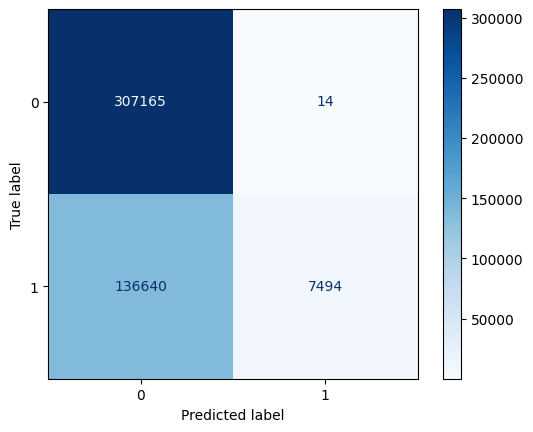

                precision    recall  f1-score   support

Normal Traffic       0.69      1.00      0.82    307179
        Attack       1.00      0.05      0.10    144134

      accuracy                           0.70    451313
     macro avg       0.85      0.53      0.46    451313
  weighted avg       0.79      0.70      0.59    451313



In [154]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred, target_names=['Normal Traffic', 'Attack']))

# FGSM - targeted byte positions only

In [18]:
import numpy as np
import tensorflow as tf

def fgsm_attack_5g_fields(
    model,
    X_attack,
    y_true,
    epsilon=0.01,
    # canonical byte indices (0-based)
    idx_ip_id=(18, 19),
    idx_gtp_teid=(46, 47, 48, 49),
    idx_tcp_sport=(70, 71),
    idx_tcp_tsval=(98, 99, 100, 101),   # may be partially present if L<102
):
    """
    FGSM on selected 5G fields; tolerates feature lengths where some bytes are missing.
    Accepts X_attack as (N,L) or (N,L,1), bytes [0..255] or normalized floats [0,1].
    Returns uint8 with the same rank as input.
    """
    x = np.asarray(X_attack)
    if x.ndim == 2:
        N, L = x.shape
        x_exp = x[:, :, None]
        squeeze_back = True
    elif x.ndim == 3 and x.shape[2] == 1:
        N, L, _ = x.shape
        x_exp = x
        squeeze_back = False
    else:
        raise ValueError(f"Expected (N,L) or (N,L,1), got {x.shape}")

    # Build the actual target index list, filtered by length L
    all_targets = list(idx_ip_id) + list(idx_gtp_teid) + list(idx_tcp_sport) + list(idx_tcp_tsval)
    targets_in_range = [i for i in all_targets if i < L]
    if not targets_in_range:
        raise ValueError(f"No target indices fall within feature length L={L}.")

    # Detect scale and prepare tensors
    if np.issubdtype(x.dtype, np.floating) and x.max() <= 1.0000001:
        x_norm = x_exp.astype(np.float32)
        x_bytes = np.clip(np.rint(x_norm * 255.0), 0, 255).astype(np.uint8)
    else:
        x_bytes = x_exp.astype(np.uint8)
        x_norm = x_bytes.astype(np.float32) / 255.0

    x_tensor = tf.convert_to_tensor(x_norm, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_tensor = tf.reshape(y_tensor, (-1, 1))

    # Gradients
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        preds = model(x_tensor)
        loss = tf.keras.losses.binary_crossentropy(y_tensor, preds)
    grad = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(grad)

    # Mask only available target indices
    mask = np.zeros_like(x_norm, dtype=np.float32)
    for idx in targets_in_range:
        mask[:, idx, 0] = 1.0
    mask_tf = tf.convert_to_tensor(mask, dtype=tf.float32)

    # FGSM step in normalized space
    x_adv_norm = tf.clip_by_value(x_tensor + epsilon * signed_grad * mask_tf, 0.0, 1.0)

    # Back to bytes
    x_adv = tf.round(x_adv_norm * 255.0)
    x_adv = tf.clip_by_value(x_adv, 0.0, 255.0)
    x_adv_uint8 = x_adv.numpy().astype(np.uint8)

    # -------- Constraints --------
    # Enforce tcp.srcport >= 1 only if both bytes 70–71 exist
    i_sp, j_sp = idx_tcp_sport
    if j_sp < L:  # both present since i_sp<j_sp
        sp = (x_adv_uint8[:, i_sp, 0].astype(np.uint16) << 8) | x_adv_uint8[:, j_sp, 0].astype(np.uint16)
        sp = np.where(sp == 0, 1, sp)
        x_adv_uint8[:, i_sp, 0] = (sp >> 8).astype(np.uint8)
        x_adv_uint8[:, j_sp, 0] = (sp & 0xFF).astype(np.uint8)
    # ip.id, gtp.teid, tcp.tsval: no extra projection needed (any byte values are valid);
    # if tsval is partial (e.g., only bytes 98–99), we still perturb those available bytes safely.

    return x_adv_uint8[:, :, 0] if squeeze_back else x_adv_uint8


In [19]:
# FGSM attack on selected bytes
x_adv = fgsm_attack_5g_fields(model, X_attack_test, y_attack_test, epsilon=0.1)

In [20]:
x_adv.shape

(144134, 100)

In [23]:
X_test_normal.shape

(307179, 100, 1)

In [24]:
x_adv = x_adv[..., np.newaxis]
print(x_adv.shape)

(144134, 100, 1)


In [25]:
# x_adv_normalized already has shape (N, 100, 1)
x_adv_normalized = x_adv.astype(np.float32) / 255.0
X_test_combined = np.vstack((X_test_normal, x_adv_normalized))
y_test_combined = np.hstack((y_test_normal, y_attack_test))


In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test_combined)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary

accuracy = accuracy_score(y_test_combined, y_pred)
precision = precision_score(y_test_combined, y_pred)
recall = recall_score(y_test_combined, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

14104/14104 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 0.99


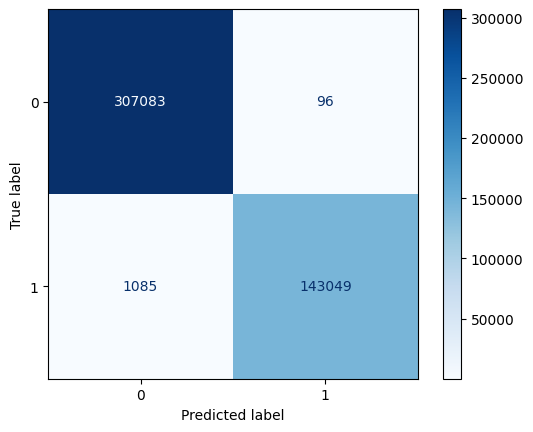

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    307179
        Attack       1.00      0.99      1.00    144134

      accuracy                           1.00    451313
     macro avg       1.00      1.00      1.00    451313
  weighted avg       1.00      1.00      1.00    451313



In [27]:
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test_combined, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Print detailed classification report
print(classification_report(y_test_combined, y_pred, target_names=['Normal Traffic', 'Attack']))

In [28]:
from scapy.all import Ether, wrpcap
import numpy as np

def patch_packet_with_adv_bytes(pkt, adv_bytes, target_indices, tolerate_short=True):
    """
    Patch 'pkt' at the given byte offsets using values from 'adv_bytes' (normalized [0,1] or uint8).
    Only bytes that actually differ are overwritten.
    Returns a new Scapy Ether packet, or the original pkt if nothing changed.
    If pkt is shorter than an index and tolerate_short=True, that index is skipped.
    """
    raw = bytearray(bytes(pkt))

    # adv_bytes can be shape (100, 1), (100,), etc. -> flatten
    vec = np.asarray(adv_bytes).squeeze()
    if vec.ndim != 1:
        raise ValueError(f"adv_bytes must be 1-D after squeeze, got {vec.shape}")

    # Normalize to uint8 if needed
    if np.issubdtype(vec.dtype, np.floating):
        vec_bytes = np.clip(np.rint(vec * 255.0), 0, 255).astype(np.uint8)
    else:
        vec_bytes = vec.astype(np.uint8)

    changed = False
    for idx in target_indices:
        if idx < 0:
            continue
        if idx >= len(raw):
            if tolerate_short:
                continue
            else:
                return None
        new_b = int(vec_bytes[idx])
        if raw[idx] != new_b:
            raw[idx] = new_b
            changed = True

    if not changed:
        return pkt  # no modification

    # Rebuild as Ether packet (since IoT/5G pcap has Ethernet linktype)
    return Ether(bytes(raw))


def save_adv_packets(original_packets, adv_array, output_path, target_indices):
    """
    original_packets: iterable of Scapy packets (Ether/IP/TCP/GTP…)
    adv_array: np.ndarray of shape (N, L, 1) or (N, L); normalized [0,1] or uint8
    target_indices: list/tuple of byte positions to allow modifications
    """
    X = np.asarray(adv_array)
    if X.ndim == 3 and X.shape[2] == 1:
        X = X[:, :, 0]
    elif X.ndim != 2:
        raise ValueError(f"adv_array must be (N,L,1) or (N,L), got {X.shape}")

    patched_packets = []
    for pkt, adv in zip(original_packets, X):
        patched = patch_packet_with_adv_bytes(pkt, adv, target_indices)
        if patched is not None:
            patched_packets.append(patched)

    if patched_packets:
        wrpcap(output_path, patched_packets)
        print(f"✅ Saved {len(patched_packets)} adversarial packets to: {output_path}")
    else:
        print("⚠️ No packets modified, nothing saved.")


In [29]:
# Example: Only allow edits to the fields you used in FGSM
target_indices = [18, 19,        # ip.id
                  46, 47, 48, 49, # gtp.teid
                  70, 71,        # tcp.srcport
                  98, 99]        # partial tsval (since you have only 100 bytes)

save_adv_packets(packets_attack_test, x_adv, "5g_adv_packets.pcap", target_indices)


✅ Saved 144134 adversarial packets to: 5g_adv_packets.pcap


# zoo

In [30]:
import numpy as np
import tensorflow as tf

def _bce_loss_from_logits_or_probs(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def _model_loss(model, x, y_true, targeted=False, y_target=None):
    x_tensor = tf.convert_to_tensor(x[None, ...], dtype=tf.float32)  # shape (1,H,W,1)
    pred = model(x_tensor)

    if targeted:
        if y_target is None:
            raise ValueError("y_target must be provided for targeted=True")
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_target)]], dtype=tf.float32), pred)
        # targeted: minimize loss toward y_target
        return loss[0]
    else:
        loss = _bce_loss_from_logits_or_probs(tf.convert_to_tensor([[float(y_true)]], dtype=tf.float32), pred)
        # untargeted: maximize loss w.r.t true label -> return +loss
        return loss[0]

def _zoo_estimate_grad(model, x, y_true, coords, fd_eta, targeted=False, y_target=None):
    """
    Symmetric finite-difference gradient estimate on selected flat coords.
    Supports ANY x shape (e.g., (L,1), (L,), (H,W), (H,W,C)).
    Returns grad_est with same shape as x (np.float32).
    """
    x = x.astype(np.float32, copy=True)
    orig_shape = x.shape

    x_flat = x.reshape(-1)
    grad_flat = np.zeros_like(x_flat, dtype=np.float32)

    for idx in coords:
        orig = x_flat[idx]

        # +eta
        x_flat[idx] = np.clip(orig + fd_eta, 0.0, 1.0)
        f_plus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # -eta
        x_flat[idx] = np.clip(orig - fd_eta, 0.0, 1.0)
        f_minus = float(_model_loss(model, x_flat.reshape(orig_shape), y_true, targeted, y_target))

        # restore
        x_flat[idx] = orig

        grad_flat[idx] = (f_plus - f_minus) / (2.0 * fd_eta)

    return grad_flat.reshape(orig_shape)

def zoo_attack(
    model,
    x,
    y_true,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng=None,
    verbose=False
):
    """
    ZOO attack for a single sample x with ANY shape (e.g., (L,1) for Conv1D).
    L_inf constraint with radius epsilon around original x.
    """
    if rng is None:
        rng = np.random.default_rng()

    x0 = x.astype(np.float32).copy()
    x_adv = x0.copy()

    flat_len = x_adv.size
    all_coords = np.arange(flat_len)

    for t in range(iters):
        coords = rng.choice(all_coords, size=min(coord_batch, flat_len), replace=False)

        g = _zoo_estimate_grad(model, x_adv, y_true, coords, fd_eta, targeted=targeted, y_target=y_target)

        # Make sparse update only on sampled coords (optional)
        if coord_batch < flat_len:
            mask = np.zeros(flat_len, dtype=np.float32)
            mask[coords] = 1.0
            g = (g.reshape(-1) * mask).reshape(x_adv.shape)

        step = -lr * np.sign(g) if targeted else lr * np.sign(g)
        x_adv = x_adv + step

        # Project to L_inf ball around x0 and clip to [0,1]
        x_adv = np.clip(x_adv, x0 - epsilon, x0 + epsilon)
        x_adv = np.clip(x_adv, 0.0, 1.0)

        if verbose and (t % max(1, iters // 10) == 0 or t == iters - 1):
            current_loss = float(_model_loss(model, x_adv, y_true, targeted, y_target))
            print(f"[ZOO] iter {t+1}/{iters} | loss={current_loss:.6f}")

    return x_adv.astype(np.float32)


from tqdm import tqdm

def zoo_attack_batch(
    model,
    X,
    y,
    epsilon=0.2,
    iters=300,
    fd_eta=1e-3,
    lr=1e-2,
    coord_batch=1024,
    targeted=False,
    y_target=None,
    rng_seed=42,
    verbose_every=0
):
    """
    Batched convenience wrapper over zoo_attack with tqdm progress bar.
    X: (N,H,W,1) in [0,1]
    y: (N,) in {0,1}
    Returns X_adv of same shape.
    """
    rng = np.random.default_rng(rng_seed)
    X_adv = np.empty_like(X, dtype=np.float32)
    N = X.shape[0]

    for i in tqdm(range(N), desc="ZOO attack samples"):
        ve = (verbose_every and ((i % verbose_every) == 0))
        X_adv[i] = zoo_attack(
            model,
            X[i],
            float(y[i]),
            epsilon=epsilon,
            iters=iters,
            fd_eta=fd_eta,
            lr=lr,
            coord_batch=coord_batch,
            targeted=targeted,
            y_target=(int(y_target) if y_target is not None else None),
            rng=rng,
            verbose=ve
        )
    return X_adv

In [31]:

X_test_attack_zoo = zoo_attack_batch(
    model,
    X_test_attack[:200],
    y_test_attack[:200],
    epsilon=0.2,
    iters=20,
    fd_eta=1e-3,
    lr=0.1,
    coord_batch=248,
    targeted=False,
    y_target=None,
    rng_seed=123,
    verbose_every=30
)

ZOO attack samples:   0%|          | 0/200 [00:00<?, ?it/s]

[ZOO] iter 1/20 | loss=1.717264
[ZOO] iter 3/20 | loss=10.630729
[ZOO] iter 5/20 | loss=13.516227
[ZOO] iter 7/20 | loss=14.267469
[ZOO] iter 9/20 | loss=14.222673
[ZOO] iter 11/20 | loss=13.990528
[ZOO] iter 13/20 | loss=14.573024
[ZOO] iter 15/20 | loss=14.507422
[ZOO] iter 17/20 | loss=14.142825
[ZOO] iter 19/20 | loss=14.633036
[ZOO] iter 20/20 | loss=15.576931


ZOO attack samples:  15%|█▌        | 30/200 [17:32<1:40:00, 35.29s/it]

[ZOO] iter 1/20 | loss=4.288791
[ZOO] iter 3/20 | loss=12.999262
[ZOO] iter 5/20 | loss=13.460558
[ZOO] iter 7/20 | loss=13.347027
[ZOO] iter 9/20 | loss=14.362174
[ZOO] iter 11/20 | loss=15.298686
[ZOO] iter 13/20 | loss=14.679689
[ZOO] iter 15/20 | loss=15.592676
[ZOO] iter 17/20 | loss=15.580504
[ZOO] iter 19/20 | loss=15.580504
[ZOO] iter 20/20 | loss=14.810182


ZOO attack samples:  30%|███       | 60/200 [35:06<1:20:57, 34.70s/it]

[ZOO] iter 1/20 | loss=2.234750
[ZOO] iter 3/20 | loss=12.190642
[ZOO] iter 5/20 | loss=10.672790
[ZOO] iter 7/20 | loss=12.959667
[ZOO] iter 9/20 | loss=13.889276
[ZOO] iter 11/20 | loss=14.282142
[ZOO] iter 13/20 | loss=17.568640
[ZOO] iter 15/20 | loss=17.023058
[ZOO] iter 17/20 | loss=18.147680
[ZOO] iter 19/20 | loss=17.770666
[ZOO] iter 20/20 | loss=16.847185


ZOO attack samples:  45%|████▌     | 90/200 [52:26<1:02:49, 34.27s/it]

[ZOO] iter 1/20 | loss=12.315292
[ZOO] iter 3/20 | loss=25.199854
[ZOO] iter 5/20 | loss=28.149124
[ZOO] iter 7/20 | loss=28.292286
[ZOO] iter 9/20 | loss=27.850857
[ZOO] iter 11/20 | loss=26.800396
[ZOO] iter 13/20 | loss=27.806223
[ZOO] iter 15/20 | loss=25.760860
[ZOO] iter 17/20 | loss=27.225622
[ZOO] iter 19/20 | loss=26.432940
[ZOO] iter 20/20 | loss=25.200081


ZOO attack samples:  60%|██████    | 120/200 [1:09:50<46:17, 34.72s/it]

[ZOO] iter 1/20 | loss=9.746122
[ZOO] iter 3/20 | loss=20.734728
[ZOO] iter 5/20 | loss=24.948795
[ZOO] iter 7/20 | loss=28.346876
[ZOO] iter 9/20 | loss=29.254509
[ZOO] iter 11/20 | loss=28.825058
[ZOO] iter 13/20 | loss=29.514360
[ZOO] iter 15/20 | loss=27.973650
[ZOO] iter 17/20 | loss=29.758783
[ZOO] iter 19/20 | loss=30.423132
[ZOO] iter 20/20 | loss=30.721817


ZOO attack samples:  75%|███████▌  | 150/200 [1:27:19<28:47, 34.55s/it]

[ZOO] iter 1/20 | loss=7.565904
[ZOO] iter 3/20 | loss=20.658154
[ZOO] iter 5/20 | loss=24.437496
[ZOO] iter 7/20 | loss=24.515244
[ZOO] iter 9/20 | loss=27.846256
[ZOO] iter 11/20 | loss=28.971830
[ZOO] iter 13/20 | loss=29.495060
[ZOO] iter 15/20 | loss=28.115835
[ZOO] iter 17/20 | loss=29.437557
[ZOO] iter 19/20 | loss=29.604126
[ZOO] iter 20/20 | loss=26.204323


ZOO attack samples:  90%|█████████ | 180/200 [1:44:42<11:35, 34.78s/it]

[ZOO] iter 1/20 | loss=9.324039
[ZOO] iter 3/20 | loss=21.240160
[ZOO] iter 5/20 | loss=23.528214
[ZOO] iter 7/20 | loss=25.690603
[ZOO] iter 9/20 | loss=24.670149
[ZOO] iter 11/20 | loss=27.065323
[ZOO] iter 13/20 | loss=27.513424
[ZOO] iter 15/20 | loss=28.169704
[ZOO] iter 17/20 | loss=28.121988
[ZOO] iter 19/20 | loss=28.065922
[ZOO] iter 20/20 | loss=27.892317


ZOO attack samples: 100%|██████████| 200/200 [1:56:14<00:00, 34.87s/it]


In [32]:
# ---- Rebuild the (scaled) test set and labels ----
X_test_combined = np.vstack((X_test_normal, X_test_attack_zoo))
y_test_combined = np.hstack((y_test_normal, y_test_attack[:200]))

from sklearn.utils import shuffle
X_test_adv_final, y_test_adv_final = shuffle(
    X_test_combined, y_test_combined, random_state=1
)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get predictions
y_pred = model.predict(X_test_adv_final)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_adv_final, y_pred)
precision = precision_score(y_test_adv_final, y_pred, average='weighted')
recall = recall_score(y_test_adv_final, y_pred, average='weighted')

# Print results
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


9606/9606 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Test Accuracy: 99.90%
Test Precision: 99.87%
Test Recall: 99.90%


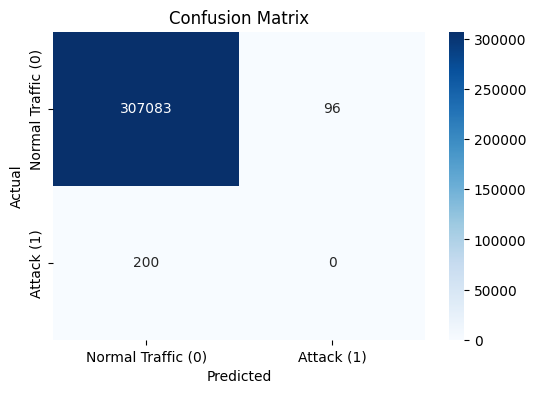

                precision    recall  f1-score   support

Normal Traffic       1.00      1.00      1.00    307179
        Attack       0.00      0.00      0.00       200

      accuracy                           1.00    307379
     macro avg       0.50      0.50      0.50    307379
  weighted avg       1.00      1.00      1.00    307379



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test_adv_final, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Traffic (0)', 'Attack (1)'], yticklabels=['Normal Traffic (0)', 'Attack (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification report
print(classification_report(y_test_adv_final, y_pred, target_names=['Normal Traffic', 'Attack']))


In [37]:
# x_adv_normalized: output of fgsm_attack (normalized)
x_adv_uint8 = (X_test_attack_zoo * 255).astype(np.uint8)
print(len(packets_attack_test[:200]))

save_patched_packets(packets_attack_test[:200], x_adv_uint8, r"C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\5g_zoo_full_modified.pcap")

200
✅ Saved 32/200 FGSM-modified packets to C:\Users\ulami\Desktop\datasety\5G-NIDD_pcap\5g_zoo_full_modified.pcap (skipped 168)
